In [84]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np


import jax
import jax.numpy as jnp
from jax import nn as jax_nn
from jax.config import config; config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=32) 
from jax import jacfwd, jacrev
from jax import grad as jax_grad

import torch
import torch.nn as nn
from torch.autograd import Variable

from copy import deepcopy

!pip install nlopt
import nlopt

from utils.datasets import construct_toy_dataset
from utils.utils import TheoremChecker

In [85]:
torch.set_default_dtype(torch.float64)
class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out, w_in, w_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(w_in)
    self.linear2.weight = torch.nn.Parameter(w_out)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [86]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[1], [-1], [1], [-1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [87]:
D_in, H_teacher, H_student, D_out = 2, 4, 5, 1
dataset, labels = construct_toy_dataset()
tensor_dataset, tensor_labels = torch.DoubleTensor(dataset), torch.DoubleTensor(labels)

teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
y_labels = teacher_model(tensor_dataset).detach()

In [88]:
jnp_inputs = jnp.array(dataset, dtype=jnp.float64)
jnp_labels = jnp.array(labels, dtype=jnp.float64)

def predict(w_in, w_out):
  return w_out @ jnp.transpose(jax_nn.sigmoid(jnp_inputs @ jnp.transpose(w_in)))

def loss(w):
  network_size = int(len(w) / 3)
  w_in = w[0 : 2 * network_size].reshape(network_size, D_in)
  w_out = w[2 * network_size : ].reshape(1, network_size)
  preds = jnp.transpose(predict(w_in, w_out))
  return jnp.mean(jnp.square(preds - jnp_labels))

def hessian(f):
  return jacfwd(jacrev(f))

def third_order_tensor(f):
    return jacfwd(jacrev(jacfwd(f)))

def fourth_order_tensor(f):
    return jacfwd(jacfwd(jacfwd(jax_grad(f))))

In [89]:
data = pd.read_csv('experiments_data_student_5.csv', float_precision='round_trip')
len(data)

1000

In [90]:
sample_point = data.loc[24]
sample_point['gradient norm']

9.595196601969155e-11

In [91]:
sample_point['loss']

0.00011474520184703572

In [92]:
def extract_weights(data_point):
  incoming_weights_x = []
  incoming_weights_y = []
  outgoing_weights = []

  for i in range(0, int(data_point['student size'])):
    neuron_traj_x = np.fromstring(data_point['neuron_' + str(i) + '_traj_x'][1:-1], dtype=float, sep=',')
    neuron_traj_y = np.fromstring(data_point['neuron_' + str(i) + '_traj_y'][1:-1], dtype=float, sep=',')
    incoming_weights_x.append(neuron_traj_x[-1])
    incoming_weights_y.append(neuron_traj_y[-1])
    neuron_traj_out = np.fromstring(data_point['neuron_' + str(i) + '_a'][1:-1], dtype=float, sep=',')
    outgoing_weights.append(neuron_traj_out[-1])

  return incoming_weights_x, incoming_weights_y, outgoing_weights

In [93]:
incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(sample_point)
local_min = np.array([incoming_weights_x[0], incoming_weights_y[0],
             incoming_weights_x[1], incoming_weights_y[1],
             incoming_weights_x[2], incoming_weights_y[2],
             incoming_weights_x[3], incoming_weights_y[3],
             incoming_weights_x[4], incoming_weights_y[4],
             outgoing_weights[0], outgoing_weights[1], outgoing_weights[2],
             outgoing_weights[3], outgoing_weights[4]])

In [94]:
min_dist = np.inf
idx_neuron1 = None
idx_neuron2 = None

for i in range(H_student):
  current_neuron = np.array([incoming_weights_x[i], incoming_weights_y[i]])
  for j in range(i + 1, H_student):
    potential_closest_neuron = np.array([incoming_weights_x[j], incoming_weights_y[j]])
    if min_dist > np.linalg.norm(current_neuron - potential_closest_neuron):
      min_dist = np.linalg.norm(current_neuron - potential_closest_neuron)
      idx_neuron1 = i
      idx_neuron2 = j

w_in = np.array([[incoming_weights_x[0], incoming_weights_y[0]],
                  [incoming_weights_x[1], incoming_weights_y[1]],
                  [incoming_weights_x[2], incoming_weights_y[2]],
                  [incoming_weights_x[3], incoming_weights_y[3]],
                  [incoming_weights_x[4], incoming_weights_y[4]]], dtype=np.float64)
w_out = np.array([outgoing_weights], dtype=np.float64)
print(loss(jnp.append(w_in.reshape(H_student * D_in), w_out.reshape(H_student))))

0.00011474520184703579


In [95]:
def pytorch_regularized_loss(output, target):
    loss = torch.mean((output - target) ** 2)
    return loss

def regularized_first_order_train(model, x, y_labels,  N = 10, Ninner = 10 ** 3, Nstart = 10):
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
  psi = 1

  loss_vals = []

  for i in range(1, N + 1):
    loss_tmp = []
    for j in range(1, Ninner + 1):
      y = model(x)

      model_params = []
      for param in model.parameters():
        model_params.append(param)
      model_params_w_in = model_params[0]
      model_params_w_out = model_params[1]
      
      neuron1 = torch.cat((model_params_w_in[idx_neuron1, :], model_params_w_out[:, idx_neuron1]), dim=-1)
      neuron2 = torch.cat((model_params_w_in[idx_neuron2, :], model_params_w_out[:, idx_neuron2]), dim=-1)
      # neuron1 = model_params_w_in[idx_neuron1, :]
      # neuron2 = model_params_w_in[idx_neuron2, :]
      # print(neuron1, neuron2)
      
      loss = pytorch_regularized_loss(y, y_labels) + psi * torch.norm(neuron1 - neuron2)
    
      loss_grad = torch.autograd.grad(loss, model.parameters(), retain_graph=True)

      loss_tmp.append(loss.item())
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
      if i == 1 and (j % Nstart == 0) and j < Ninner:
        loss_vals.append(np.mean(loss_tmp[j - Nstart  : j]))

    loss_vals.append(np.mean(loss_tmp))
    
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    # print(g_vector)
    print("Iteration: %d, loss: %s, gradient norm: %s" % (Ninner * i, np.mean(loss_tmp), torch.norm(g_vector)))
    
#   final_weights = train_second_order(model)
#   final_weights = regularized_second_order_train(jnp.append(
#                       deepcopy(model.linear1.weight.data.detach().numpy().reshape(H_student * 2)),
#                       deepcopy(model.linear2.weight.data.detach().numpy().reshape(H_student))))
#   return final_weights
  return np.append(deepcopy(model.linear1.weight.data.detach().numpy().reshape(H_student * 2)),
                     deepcopy(model.linear2.weight.data.detach().numpy().reshape(H_student)))

In [96]:
dummy_model = DummyNetwork(D_in, H_student, D_out, torch.DoubleTensor(w_in), torch.DoubleTensor(w_out))

In [97]:
final_weights = regularized_first_order_train(dummy_model, tensor_dataset, y_labels)

Iteration: 1000, loss: 0.04491015061296411, gradient norm: tensor(1.4142)
Iteration: 2000, loss: 0.00111474520184704, gradient norm: tensor(1.4142)
Iteration: 3000, loss: 0.0011147452018470368, gradient norm: tensor(1.4142)
Iteration: 4000, loss: 0.0011147452018470355, gradient norm: tensor(1.4142)
Iteration: 5000, loss: 0.0011147452018470366, gradient norm: tensor(1.4142)
Iteration: 6000, loss: 0.0011147452018470357, gradient norm: tensor(1.4142)
Iteration: 7000, loss: 0.0011147452018470361, gradient norm: tensor(1.4142)
Iteration: 8000, loss: 0.0011147452018470357, gradient norm: tensor(1.4142)
Iteration: 9000, loss: 0.0011147452018470361, gradient norm: tensor(1.4142)
Iteration: 10000, loss: 0.0011147452018470366, gradient norm: tensor(1.4142)


In [98]:
print(final_weights)
print('Gradient at this point:', jnp.linalg.norm(jax_grad(loss)(final_weights)))
w_in_torch_format = final_weights[0 : 2 * H_student].reshape(H_student, 2)
w_out_torch_format = final_weights[2 * H_student : ].reshape(H_student)

[-0.19225111866532213  0.02987191263390313  0.8385350315782469
  0.5129560725746176   2.039106557956889    1.7149326387520243
 -0.19225111879001194  0.02987191264482412  0.9181671272899552
 -0.7294739966673347  -0.39832456806155214  0.40956756506275455
  0.04216836140669694 -0.3968741176382985   0.34345317633166206]
Gradient at this point: 9.567774924932299e-11


In [99]:
# incoming_weights_x = w_in_torch_format[:, 0]
# incoming_weights_y = w_in_torch_format[:, 1]
# outgoing_weights = w_out_torch_format

In [100]:
new_incoming_weights_x = [(incoming_weights_x[idx_neuron1] + incoming_weights_x[idx_neuron2]) / 2.0]
new_incoming_weights_y = [(incoming_weights_y[idx_neuron1] + incoming_weights_y[idx_neuron2]) / 2.0]
new_outgoing_weights = [(outgoing_weights[idx_neuron1] + outgoing_weights[idx_neuron2])]


for i in range(H_student):
  if i == idx_neuron1 or i == idx_neuron2:
    continue
  new_incoming_weights_x.append(incoming_weights_x[i])
  new_incoming_weights_y.append(incoming_weights_y[i])
  new_outgoing_weights.append(outgoing_weights[i])

print(final_weights)
print(new_incoming_weights_x, new_incoming_weights_y, new_outgoing_weights)

[-0.19225111866532213  0.02987191263390313  0.8385350315782469
  0.5129560725746176   2.039106557956889    1.7149326387520243
 -0.19225111879001194  0.02987191264482412  0.9181671272899552
 -0.7294739966673347  -0.39832456806155214  0.40956756506275455
  0.04216836140669694 -0.3968741176382985   0.34345317633166206]
[-0.1922511226098793, 0.8385350328345572, 2.039106558025516, 0.918167128377758] [0.029871912975843535, 0.5129560709167732, 1.714932638668418, -0.7294739956399938] [-0.795198692814431, 0.40956756746079054, 0.04216836280729857, 0.3434531795243844]


Text(0, 0.5, 'w2')

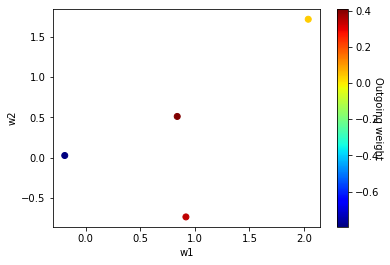

In [101]:
plt.scatter(new_incoming_weights_x,
            new_incoming_weights_y,
            c = new_outgoing_weights,
            cmap = matplotlib.cm.jet)

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

In [102]:
w_in = torch.DoubleTensor([[new_incoming_weights_x[0], new_incoming_weights_y[0]],
                           [new_incoming_weights_x[1], new_incoming_weights_y[1]],
                           [new_incoming_weights_x[2], new_incoming_weights_y[2]],
                           [new_incoming_weights_x[3], new_incoming_weights_y[3]]])
w_out = torch.DoubleTensor([new_outgoing_weights])
dummy_model = DummyNetwork(D_in, H_teacher, D_out, w_in, w_out)

In [135]:
def loss_obj(weights, grad):
  loss_val = loss(weights)
  if grad.size > 0:
    grad[:] = np.array(jax_grad(loss)(weights), dtype=np.float64)
  return np.float64(loss_val)

# def train_second_order(model):
#     num_neurons = model.linear1.weight.shape[0]
#     weights = np.append(model.linear1.weight.data.detach().numpy().reshape(num_neurons * 2),
#                         model.linear2.weight.data.detach().numpy().reshape(num_neurons))
#     lower_bound = weights - 0.5
#     upper_bound = weights + 0.5
#     opt = nlopt.opt(nlopt.LD_SLSQP, len(weights))
#     opt.set_lower_bounds(lower_bound)
#     opt.set_upper_bounds(upper_bound)
#     opt.set_min_objective(loss_obj)
#     opt.set_maxtime(5)
#     opt.set_xtol_rel(1e-10)
#     opt.set_initial_step(1e-32)
#     final_weights = opt.optimize(weights)
#     return final_weights

def train_second_order(model):
    num_neurons = model.linear1.weight.shape[0]
    weights = np.append(model.linear1.weight.data.detach().numpy().reshape(num_neurons * 2),
                        model.linear2.weight.data.detach().numpy().reshape(num_neurons))
    lower_bound = weights - 10
    upper_bound = weights + 10
    opt = nlopt.opt(nlopt.LD_SLSQP, len(weights))
    opt.set_lower_bounds(lower_bound)
    opt.set_upper_bounds(upper_bound)
    opt.set_min_objective(loss_obj)
    opt.set_maxtime(100)
    opt.set_xtol_rel(1e-20)
    opt.set_initial_step(1e-32)
    final_weights = opt.optimize(weights)
    return final_weights


In [136]:
final_weights = train_second_order(dummy_model)
print(loss(final_weights))
print(jnp.linalg.norm(jax_grad(loss)(final_weights)))

w_in_torch_format = torch.DoubleTensor(final_weights[: H_teacher * 2].reshape(H_teacher, 2))
w_out_torch_format = torch.DoubleTensor([final_weights[H_teacher * 2 :].reshape(H_teacher)])

0.00011474520184703579
7.397032905996531e-11


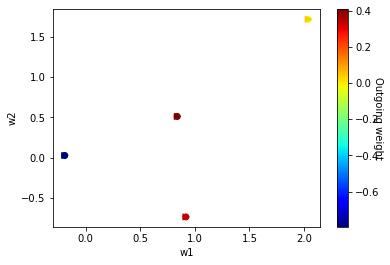

In [137]:
plt.scatter(incoming_weights_x,
            incoming_weights_y,
            c = outgoing_weights,
            cmap = matplotlib.cm.jet)

plt.scatter(w_in_torch_format[:, 0],
            w_in_torch_format[:, 1],
            c = w_out_torch_format[0],
            cmap = matplotlib.cm.jet,
            marker=">")

plt.colorbar().set_label('Outgoing weight', rotation=270)
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()

In [138]:
theorem_checker = TheoremChecker(D_in, H_teacher, D_out)

In [139]:
Y, U = theorem_checker.check_si_saddle_failure_mode(final_weights)

evals, _ = jnp.linalg.eig(Y)
print(evals)
print(U)

[0.00012701817460273582+0.j 0.00018465617112666492+0.j]
[ 4.8459245077253816e-12 -3.0119105803590005e-11]


In [108]:
def construct_si_saddle(final_weights, mu):
    num_neurons = int(len(final_weights) / 3)
    w_in_torch_format = torch.DoubleTensor(final_weights[0 : num_neurons * 2].reshape(num_neurons, 2))
    w_out_torch_format = torch.DoubleTensor([final_weights[num_neurons * 2 :].reshape(num_neurons)])

    si_saddle = np.array([])
    teacher_idx = 1

    for i in range(H_student):
      if i == idx_neuron1 or i == idx_neuron2:
        si_saddle = np.append(si_saddle, w_in_torch_format[0][0].item())
        si_saddle = np.append(si_saddle, w_in_torch_format[0][1].item())
        continue
      si_saddle = np.append(si_saddle, w_in_torch_format[teacher_idx][0].item())
      si_saddle = np.append(si_saddle, w_in_torch_format[teacher_idx][1].item())
      teacher_idx += 1

    teacher_idx = 1

    for i in range(H_student):
      if i == idx_neuron1:
        si_saddle = np.append(si_saddle,
                              mu * w_out_torch_format[0][0].item())
        continue
      if i == idx_neuron2:
        si_saddle = np.append(si_saddle,
                              (1 - mu) * w_out_torch_format[0][0].item())
        continue
      si_saddle = np.append(si_saddle,
                            w_out_torch_format[0][teacher_idx].item())
      teacher_idx += 1

    return si_saddle

def find_saddle_line(final_weights):
    saddle_smallest_u = construct_si_saddle(final_weights, -1)
    saddle_largest_u = construct_si_saddle(final_weights, 2)
    
    saddle_line_dir = (saddle_largest_u - saddle_smallest_u) / \
                       np.linalg.norm(saddle_largest_u - saddle_smallest_u)
    closest_saddle = saddle_smallest_u + saddle_line_dir * \
                     np.dot(saddle_line_dir, (local_min - saddle_smallest_u))
    optimal_mu = closest_saddle[2 * H_student + idx_neuron1] / w_out_torch_format[0][0].item()
    directional_vector = local_min - closest_saddle
    
    return closest_saddle, optimal_mu, directional_vector

In [140]:
closest_saddle, optimal_mu, directional_vector = find_saddle_line(final_weights)
print(optimal_mu)

0.23682706263030986


In [141]:
evals, _ = jnp.linalg.eig(optimal_mu * (1 - optimal_mu) * Y)
print(evals)

[2.2957265517388563e-05+0.j 3.3374757299400526e-05+0.j]


In [111]:
mus = []
second_derivs = []
third_derivs = []
fourth_derivs = []
ratios_second_third = []

for mu in np.arange(optimal_mu - 1, optimal_mu + 1, 0.01):
    saddle = construct_si_saddle(final_weights, mu)
    H = hessian(loss)(saddle)
    H = (H + H.T) / 2
    evals, evectors = jnp.linalg.eigh(H)
    smallest_evector = evectors[:, jnp.argmin(evals)]
                
    first_dir_deriv = lambda weights, evector: jnp.dot(jax_grad(loss)(weights),
                                               evector)
    second_dir_deriv = lambda weights, evector: jnp.dot(jax_grad(first_dir_deriv)(weights,
                                                                                 evector),
                                                evector)
    third_dir_deriv = lambda weights, evector: jnp.dot(jax_grad(second_dir_deriv)(weights,
                                                                                 evector),
                                               evector)
    fourth_dir_deriv = lambda weights, evector: jnp.dot(jax_grad(third_dir_deriv)(weights,
                                                                                 evector),
                                               evector)

    third_deriv_pos = third_dir_deriv(saddle, smallest_evector)
    third_deriv_neg = third_dir_deriv(saddle, -smallest_evector)
    
    mus.append(mu)
    if third_deriv_pos <= 0:
        smallest_evector = -smallest_evector
    
    second_deriv = second_dir_deriv(saddle, smallest_evector)
    third_deriv = third_dir_deriv(saddle, smallest_evector)
    fourth_deriv = fourth_dir_deriv(saddle, smallest_evector)
        
    second_derivs.append(second_deriv)
    third_derivs.append(third_deriv)
    fourth_derivs.append(fourth_deriv)
    ratios_second_third.append(second_deriv / third_deriv)

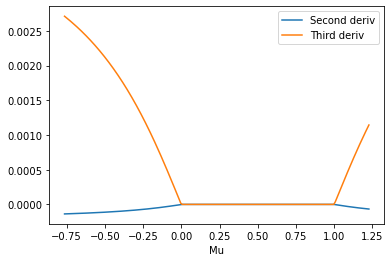

In [112]:
plt.plot(mus, second_derivs, label='Second deriv')
plt.plot(mus, third_derivs, label='Third deriv')
plt.xlabel('Mu')
plt.legend()
plt.show()

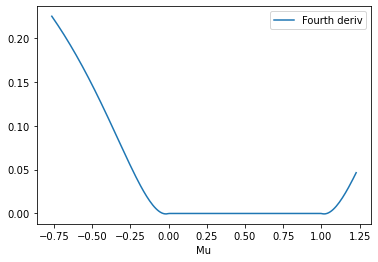

In [113]:
plt.plot(mus, fourth_derivs, label='Fourth deriv')
plt.xlabel('Mu')
plt.legend()
plt.show()

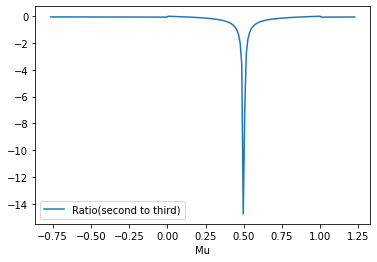

In [114]:
plt.plot(mus, ratios_second_third, label='Ratio(second to third)')
plt.xlabel('Mu')
plt.legend()
plt.show()

In [115]:
m = 10
n = 5
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

first_dir_deriv = lambda weights, evector: jnp.dot(jax_grad(loss)(weights),
                                               evector)
second_dir_deriv = lambda weights, evector: jnp.dot(jax_grad(first_dir_deriv)(weights,
                                                                             evector),
                                            evector)
third_dir_deriv = lambda weights, evector: jnp.dot(jax_grad(second_dir_deriv)(weights,
                                                                             evector),
                                           evector)
fourth_dir_deriv = lambda weights, evector: jnp.dot(jax_grad(third_dir_deriv)(weights,
                                                                             evector),
                                           evector)

print(len(closest_saddle))
print(third_order_tensor(loss)(closest_saddle).shape)
# Construct the problem.
A = third_order_tensor(loss)(closest_saddle)

15
(15, 15, 15)


In [116]:
from utils.training import BSolver, FourthOrderSolver
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
H = hessian(loss)(closest_saddle)
H = (H + H.T) / 2
evals, evectors = jnp.linalg.eigh(H)
smallest_evector = evectors[:, jnp.argmin(evals)]
second_smallest_evector = evectors[:, jnp.argmin(evals)]

In [118]:
bsolver = BSolver(A, H, evectors[:, 1])

In [119]:
sol = bsolver.compute_B(smallest_evector)

In [120]:
print(jnp.linalg.norm(sol))
if third_dir_deriv(closest_saddle, -sol) > 0:
    sol = -sol

1.0


In [121]:
print ("third dir derivative (smallest evector) and third dir deriv (sol):")
print(third_dir_deriv(closest_saddle, smallest_evector))
print(third_dir_deriv(closest_saddle, sol))
print("smallest eval:", evals[0])
print("sol.T @ H @ sol:", sol.T @ H @ sol)
print("smallest evector:", smallest_evector)
print("sol", sol)

third dir derivative (smallest evector) and third dir deriv (sol):
-1.9061740580334038e-16
8.973643025393482e-22
smallest eval: -2.6428721105509822e-17
sol.T @ H @ sol: 9.694354521363118e-20
smallest evector: [-3.6402807131817517e-07 -3.4537583211639282e-07 -2.1816603921944988e-12
 -2.1200442834646321e-12 -2.4038970020509499e-11 -2.4013876526594844e-11
  1.1296560654808428e-07  1.0717675580284994e-07  1.1194136077104717e-13
 -7.3875376096076704e-14  7.0710678118607884e-01 -4.4537813324386848e-13
  1.1707102443818045e-12 -7.0710678118682069e-01  1.6940861072641939e-14]
sol [ 3.6391328161900646e-07  3.4505514818852970e-07  4.9121377251242709e-11
 -4.6024470061315850e-11  2.6610977498116029e-11  2.1115794590684188e-11
 -1.1308172755015671e-07 -1.0678975559786323e-07  2.6248378232675183e-11
  1.6765099215768032e-11 -7.0710678127157711e-01  1.0007541499544809e-10
  8.6857345776305124e-11  7.0710678110132308e-01  1.4494385821896144e-10]


## Second, third, and forth derivs. in the dir. of local_min - closest_saddle

In [122]:
u = (local_min - closest_saddle) / np.linalg.norm(local_min - closest_saddle)
print ('Second deriv.:', second_dir_deriv(closest_saddle, u))
print ('Third deriv.:', third_dir_deriv(closest_saddle, u))
print ('Fourth deriv.:', fourth_dir_deriv(closest_saddle, u))

Second deriv.: 0.0002652202577231706
Third deriv.: 0.0025934370907542362
Fourth deriv.: 0.3184638021568301


## Minimizing forth dir. deriv. at the closest saddle

In [123]:
fot = fourth_order_tensor(loss)(closest_saddle)
fourth_solver = FourthOrderSolver(fot, H, evectors[:, 1])

In [124]:
sol = fourth_solver.compute_min(smallest_evector)
print(fourth_solver.compute_loss(sol))

[-4.9619778419921912e-06 -5.3232463630733368e-06  5.2250935192721566e-14
 -7.4569815510383268e-15  4.3136230308401173e-16 -4.8493180933468600e-16
  4.9619765265226353e-06  5.3232454891427160e-06  3.3563757006046682e-13
  3.2539668091710056e-13  4.8425798011902944e-12  8.9927255725573351e-13
  9.1580196784179075e-13 -1.9115345147151588e-12  5.0582049431477750e-13]
[ 9.8859171852673202e-05  1.1929012015522605e-04 -1.0769267716415188e-12
  2.1187594994054593e-13 -9.6665184057659676e-15  1.2067408995151268e-14
 -9.8857954742522501e-05 -1.1928930325374551e-04 -7.0681312337808720e-12
 -6.8879607785716323e-12  1.4890545385868667e-09 -1.8602042885036635e-11
 -1.8848802045106978e-11 -1.5514396638462601e-09 -1.0351893699295885e-11]
[-2.9659369507760536e-07  2.7646633162000167e-07  1.5165785617593978e-15
  2.4120545928802654e-15 -2.3291185520613596e-17  8.1850475743902233e-17
  2.9659361297856569e-07 -2.7646636366947931e-07  2.9715637764484029e-15
  1.2947538994335346e-15  9.4432196971885199e-15 

In [125]:
print('Norm of sol:', jnp.linalg.norm(sol))
print('Dot product (sol and smallest evector):', jnp.dot(sol, evectors[:, 0]))
print('Dot product (sol and second smallest evector):', jnp.dot(sol, evectors[:, 1]))
print('sol @ H @ sol:', sol @ H @ sol)

Norm of sol: 1.0
Dot product (sol and smallest evector): 0.9999999999998618
Dot product (sol and second smallest evector): -1.781255285246894e-19
sol @ H @ sol: -2.2419364904294915e-22


## Sampling u vectors for the fourth dir. deriv. at si saddle

In [126]:
num_neg_fourth_deriv = 0
num_total = 0

# temp = smallest_evector + 0.001
# temp /= np.linalg.norm(temp)
# print(temp @ H @ temp)

for i in range(10):
    mu, sigma = 0, 1
    n = len(closest_saddle)
    u = np.random.normal(mu, sigma, n)
    u /= np.linalg.norm(u)
    if second_dir_deriv(closest_saddle, u) <= 0:
        num_total += 1
        if fourth_dir_deriv(closest_saddle, u) < 0:
            print('negative')
            num_neg_fourth_deriv += 1

print(num_neg_fourth_deriv / num_total)

ZeroDivisionError: division by zero

## Sampling on the ball of radius R

In [ ]:
R = np.linalg.norm(local_min - closest_saddle)
print(R)

In [ ]:
for i in range(500):
    mu, sigma = 0, 1
    n = len(closest_saddle)
    normal_array = np.random.normal(mu, sigma, n)
    normal_array /= np.linalg.norm(normal_array)
    uniform_val = np.random.uniform() 
    
    normal_array *= R * (uniform_val ** (1/n))
    
    csi = jnp.array(normal_array) + closest_saddle

In [ ]:
R = np.linalg.norm(local_min - closest_saddle)

In [ ]:
print(R)

In [ ]:
for i in range(500):
    mu, sigma = 0, 1
    n = len(closest_saddle)
    normal_array = np.random.normal(mu, sigma, n)
    normal_array /= np.linalg.norm(normal_array)
    uniform_val = np.random.uniform()
    
    normal_array *= R * (uniform_val ** (1/n))
    
    csi = jnp.array(normal_array) + closest_saddle
    H_csi = hessian(loss)(csi)
    H_csi = (H_csi + H_csi.T) / 2
    evals, evectors = jnp.linalg.eigh(H_csi)
    smallest_evector = evectors[:, jnp.argmin(evals)]
    
    fot = fourth_order_tensor(loss)(csi)
    fourth_order_solver = FourthOrderSolver(fot, H, second_smallest_evector)
    print(fot.shape)
    
    fourth_order_u = fourth_order_solver.compute_min(smallest_evector)

    print(second_dir_deriv(closest_saddle, fourth_order_u),
          fourth_dir_deriv(closest_saddle, fourth_order_u))
    
    # print(jnp.linalg.norm(csi - closest_saddle))